In [45]:
from pprint import pprint

import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
# model_name = "barbel-model"
# up_stable = np.load("./data/barbel/barbel-stable.mov.npy") # label 1
# down_stable = np.load("./data/barbel/barbel-up.mov.npy") # label 0


model_name = "squat-model"
up_stable = np.load("./data/squat/squat-up.mp4.npy") # label 1
down_stable = np.load("./data/squat/squat-down.mov.npy") # label 0

# model_name = "legwork-model"
# up_stable = np.load("./data/legwork/stable-down.mp4.npy") # label 1
# down_stable = np.load("./data/legwork/legwork-up.MOV.npy") # label 0

up_stable = up_stable.reshape((-1,34))
down_stable = down_stable.reshape((-1,34))

X_data = np.concatenate((up_stable, down_stable))
Y_data = np.zeros(up_stable.shape[0] + down_stable.shape[0], dtype=bool)
Y_data[0:len(up_stable)] = 1


In [46]:
# degree augmentation
new_X = []
new_Y = []

for x,y in tqdm(zip(X_data, Y_data), total=len(X_data)):

    t = 0
    while True:
        theta = np.pi/5 - np.pi/14 * t
        t+=1
        if theta < - np.pi/5:
            break
        M = np.array([[np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]])
        temp_coord_list = []
        for coord_of_x in x.reshape(17,2):
            temp_coord_list.append(np.matmul(M, coord_of_x))
        new_X.append(np.array(temp_coord_list).reshape(34))
        new_Y.append(y)

X_data = np.array(new_X)
Y_data = np.array(new_Y)




  0%|          | 0/3364 [00:00<?, ?it/s]

In [47]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(X_data,
                                                    Y_data,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1008)

In [48]:
# from sklearn.metrics import confusion_matrix
# from pprint import pprint
#
# from sklearn.linear_model import LogisticRegressionCV
#
# cls = LogisticRegressionCV(cv=10, scoring='accuracy', solver='liblinear',
#                            max_iter=1000, class_weight='balanced',
#                            n_jobs=-1)
#
# cls.fit(X=X_train, y=y_train)
# pred = cls.predict(X_test)
# pprint(confusion_matrix(y_test, pred))
#
#
# print(cls.intercept_)
# pprint(cls.coef_[0])

2.1.0
Train on 16147 samples, validate on 4037 samples
Epoch 1/35
16147/16147 [==============================] - 0s 28us/sample - loss: 0.7173 - accuracy: 0.4134 - val_loss: 0.6370 - val_accuracy: 0.9965
Epoch 2/35
16147/16147 [==============================] - 0s 6us/sample - loss: 0.5750 - accuracy: 0.9906 - val_loss: 0.5052 - val_accuracy: 1.0000
Epoch 3/35
16147/16147 [==============================] - 0s 6us/sample - loss: 0.4418 - accuracy: 1.0000 - val_loss: 0.3704 - val_accuracy: 1.0000
Epoch 4/35
16147/16147 [==============================] - 0s 6us/sample - loss: 0.3142 - accuracy: 1.0000 -

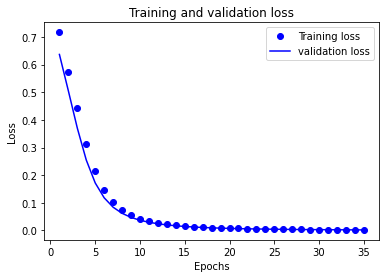

In [49]:
%matplotlib inline

# tensorflow와 tf.keras를 임포트합니다
import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt

print(tf.__version__)

model = keras.Sequential([
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])

history = model.fit(X_train, y_train, epochs=35,
                    batch_size=256, validation_data=(X_test,y_test))
history_dic = history.history
history_dic.keys()


history_dic = history.history
loss = history_dic['loss']
val_loss = history_dic['val_loss']

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [50]:
pred = model.predict(X_test)
pred[np.where(pred<0.5)] = 0
pred[np.where(pred>=0.5)] = 1
pred = pred.astype(bool).reshape(pred.shape[0])
y_test

pprint(confusion_matrix(y_test, pred))


converter = tf.lite.TFLiteConverter.from_keras_model(
    model)
tflite_model = converter.convert()

# Save the model.
with open(model_name+'.tflite', 'wb') as f:
  f.write(tflite_model)

array([[1857,    0],
       [   0, 2180]], dtype=int64)
